In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
df = pd.read_csv('manual_cleaned_emotion_classify_data.csv')
texts = df['Comment_clean'].astype(str).tolist()
labels = df['Emotion'].astype(str).tolist()

# Label encode emotions
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

# Train-test split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=67, stratify=y
)

Classes: ['anger' 'fear' 'joy']


## Models

In [4]:
# params
MAX_NUM_WORDS = 30000   # vocab size cap
MAX_SEQ_LEN = 100        # based on your length stats

PAD_IDX = 0
OOV_IDX = 1

def tokenize(text):
    return text.lower().split()

# Build vocab from training texts only
counter = Counter()
for t in X_train_texts:
    counter.update(tokenize(t))

# Most common words (reserve 0:PAD, 1:OOV)
most_common = counter.most_common(MAX_NUM_WORDS - 2)
word2idx = {"<PAD>": PAD_IDX, "<OOV>": OOV_IDX}
idx2word = {PAD_IDX: "<PAD>", OOV_IDX: "<OOV>"}

for i, (word, freq) in enumerate(most_common, start=2):
    word2idx[word] = i
    idx2word[i] = word

vocab_size = len(word2idx)
print("Vocab size:", vocab_size)


Vocab size: 7782


In [5]:
def text_to_sequence(text, word2idx, max_len=MAX_SEQ_LEN):
    tokens = tokenize(text)
    seq = []
    for tok in tokens:
        seq.append(word2idx.get(tok, OOV_IDX))
    # pad / truncate
    if len(seq) < max_len:
        seq += [PAD_IDX] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

X_train_seq = [text_to_sequence(t, word2idx, MAX_SEQ_LEN) for t in X_train_texts]
X_test_seq = [text_to_sequence(t, word2idx, MAX_SEQ_LEN) for t in X_test_texts]

X_train_seq = np.array(X_train_seq, dtype=np.int64)
X_test_seq = np.array(X_test_seq, dtype=np.int64)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)


In [6]:
EMBEDDING_DIM = 300
w2v_path = r"C:\Users\osen\Desktop\programming project\word_embeddings\pretrained_model\GoogleNews-vectors-negative300.bin"

print("Loading Word2Vec (this may take a while)...")
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)
print("Word2Vec loaded.")

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMBEDDING_DIM)).astype(np.float32)

# pad token as zeros
embedding_matrix[PAD_IDX] = np.zeros(EMBEDDING_DIM, dtype=np.float32)

for word, idx in word2idx.items():
    if word in ["<PAD>", "<OOV>"]:
        continue
    if word in w2v:
        embedding_matrix[idx] = w2v[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print("Embedding matrix:", embedding_matrix.shape)


Loading Word2Vec (this may take a while)...
Word2Vec loaded.
Embedding matrix: torch.Size([7782, 300])


Dataset & DataLoader

In [7]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_dataset = TextDataset(X_train_seq, y_train)
test_dataset = TextDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Base embedding layer

In [8]:
embedding_layer = nn.Embedding.from_pretrained(
    embeddings=embedding_matrix,
    freeze=True,
    padding_idx=PAD_IDX
)

LSTM

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim=128, num_classes=3):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(
            input_size=EMBEDDING_DIM,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        h = h_n[-1]
        h = self.dropout(h)
        logits = self.fc(h)
        return logits


BiLSTM

In [10]:
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim=128, num_classes=3):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(
            input_size=EMBEDDING_DIM,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        h_fwd = h_n[-2]
        h_bwd = h_n[-1]
        h = torch.cat([h_fwd, h_bwd], dim=1)
        h = self.dropout(h)
        logits = self.fc(h)
        return logits


GRU

In [11]:
class GRUModel(nn.Module):
    def __init__(self, embedding_layer, hidden_dim=256, num_classes=3):
        super().__init__()
        self.embedding = embedding_layer
        self.gru = nn.GRU(
            input_size=EMBEDDING_DIM,
            hidden_size=hidden_dim,
            batch_first=True,
            dropout=0.3
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, h_n = self.gru(x)
        h = h_n[-1]
        h = self.dropout(h)
        logits = self.fc(h)
        return logits


Kim CNN (Text CNN)

In [12]:
class KimCNN(nn.Module):
    def __init__(self, embedding_layer, num_filters=128, filter_sizes=(3,4,5), num_classes=3):
        super().__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=EMBEDDING_DIM,
                out_channels=num_filters,
                kernel_size=fs
            )
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        conv_outs = []
        for conv in self.convs:
            c = conv(x)
            c = torch.relu(c)
            p = torch.max(c, dim=2)[0]
            conv_outs.append(p)
        h = torch.cat(conv_outs, dim=1)
        h = self.dropout(h)
        logits = self.fc(h)
        return logits


Attention-based BiLSTM

In [13]:
class AttentionBiLSTM(nn.Module):
    def __init__(self, embedding_layer, hidden_dim=128, num_classes=3):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(
            input_size=EMBEDDING_DIM,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(x)

        scores = self.attention(outputs).squeeze(-1)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)

        context = torch.sum(outputs * weights, dim=1)
        context = self.dropout(context)
        logits = self.fc(context)
        return logits


Training 

In [14]:
def train_model(model, train_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        epoch_loss = total_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    return model


def evaluate_model(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    report = classification_report(
        all_targets,
        all_preds,
        target_names=label_encoder.classes_,
        output_dict=True
    )
    return acc, report


In [15]:
def clone_embedding(embedding_layer):
    new_emb = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(),
        freeze=embedding_layer.weight.requires_grad,
        padding_idx=PAD_IDX
    )
    return new_emb


deep_model_builders = {
    "LSTM": lambda: LSTMModel(
        clone_embedding(embedding_layer),
        hidden_dim=128,
        num_classes=num_classes
    ),
    "BiLSTM": lambda: BiLSTMModel(
        clone_embedding(embedding_layer),
        hidden_dim=128,
        num_classes=num_classes
    ),
    "GRU": lambda: GRUModel(
        clone_embedding(embedding_layer),
        hidden_dim=256,
        num_classes=num_classes
    ),
    "Kim CNN": lambda: KimCNN(
        clone_embedding(embedding_layer),
        num_filters=128,
        num_classes=num_classes
    ),
    "Attention BiLSTM": lambda: AttentionBiLSTM(
        clone_embedding(embedding_layer),
        hidden_dim=128,
        num_classes=num_classes
    ),
}

results_dl = {}
EPOCHS = 15

for name, build_fn in deep_model_builders.items():
    print(f"\n=== Training {name} ===")
    model = build_fn()
    model = train_model(model, train_loader, epochs=EPOCHS, lr=1e-3)

    print(f"Evaluating {name}...")
    acc, report = evaluate_model(model, test_loader, label_encoder)
    results_dl[name] = {"accuracy": acc, "report": report}
    print(f"{name} Test Accuracy: {acc:.4f}")


tune_configs = [
    {"hidden_dim": 64,  "lr": 1e-3},
    {"hidden_dim": 128, "lr": 1e-3},
    {"hidden_dim": 128, "lr": 5e-4},
    {"hidden_dim": 256, "lr": 1e-3},
]

best_acc = 0.0
best_cfg = None
best_report = None

for cfg in tune_configs:
    print(f"\n=== Tuning Attention BiLSTM: {cfg} ===")
    model = AttentionBiLSTM(
        clone_embedding(embedding_layer),
        hidden_dim=cfg["hidden_dim"],
        num_classes=num_classes
    )

    model = train_model(model, train_loader, epochs=15, lr=cfg["lr"])

    acc, report = evaluate_model(model, test_loader, label_encoder)
    print(f"Accuracy for cfg {cfg}: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_cfg = cfg
        best_report = report

print("\nBest Attention BiLSTM config:", best_cfg, "Accuracy:", best_acc)

# store tuned result as an extra entry
results_dl["Attention BiLSTM (tuned)"] = {
    "accuracy": best_acc,
    "report": best_report,
}



=== Training LSTM ===
Epoch 1/15 - Loss: 1.0997, Acc: 0.3228
Epoch 2/15 - Loss: 1.0989, Acc: 0.3329
Epoch 3/15 - Loss: 1.0994, Acc: 0.3304
Epoch 4/15 - Loss: 1.0988, Acc: 0.3314
Epoch 5/15 - Loss: 1.0994, Acc: 0.3205
Epoch 6/15 - Loss: 1.0992, Acc: 0.3415
Epoch 7/15 - Loss: 1.0988, Acc: 0.3365
Epoch 8/15 - Loss: 1.0988, Acc: 0.3340
Epoch 9/15 - Loss: 1.0990, Acc: 0.3289
Epoch 10/15 - Loss: 1.0992, Acc: 0.3306
Epoch 11/15 - Loss: 1.0989, Acc: 0.3306
Epoch 12/15 - Loss: 1.0990, Acc: 0.3335
Epoch 13/15 - Loss: 1.0990, Acc: 0.3279
Epoch 14/15 - Loss: 1.0991, Acc: 0.3245
Epoch 15/15 - Loss: 1.0990, Acc: 0.3300
Evaluating LSTM...
LSTM Test Accuracy: 0.3367

=== Training BiLSTM ===


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epoch 1/15 - Loss: 1.0091, Acc: 0.4561
Epoch 2/15 - Loss: 0.5399, Acc: 0.7359
Epoch 3/15 - Loss: 0.2284, Acc: 0.9351
Epoch 4/15 - Loss: 0.1203, Acc: 0.9663
Epoch 5/15 - Loss: 0.1321, Acc: 0.9629
Epoch 6/15 - Loss: 0.1764, Acc: 0.9556
Epoch 7/15 - Loss: 0.1070, Acc: 0.9707
Epoch 8/15 - Loss: 0.0667, Acc: 0.9810
Epoch 9/15 - Loss: 0.0422, Acc: 0.9891
Epoch 10/15 - Loss: 0.0359, Acc: 0.9888
Epoch 11/15 - Loss: 0.0894, Acc: 0.9770
Epoch 12/15 - Loss: 0.0400, Acc: 0.9876
Epoch 13/15 - Loss: 0.0207, Acc: 0.9937
Epoch 14/15 - Loss: 0.0205, Acc: 0.9945
Epoch 15/15 - Loss: 0.0187, Acc: 0.9945
Evaluating BiLSTM...
BiLSTM Test Accuracy: 0.9301

=== Training GRU ===


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/15 - Loss: 1.1003, Acc: 0.3340
Epoch 2/15 - Loss: 1.0991, Acc: 0.3350
Epoch 3/15 - Loss: 1.1003, Acc: 0.3218
Epoch 4/15 - Loss: 1.0992, Acc: 0.3325
Epoch 5/15 - Loss: 1.0990, Acc: 0.3354
Epoch 6/15 - Loss: 1.0992, Acc: 0.3319
Epoch 7/15 - Loss: 1.0992, Acc: 0.3281
Epoch 8/15 - Loss: 1.0992, Acc: 0.3331
Epoch 9/15 - Loss: 1.0993, Acc: 0.3327
Epoch 10/15 - Loss: 1.0991, Acc: 0.3304
Epoch 11/15 - Loss: 1.0989, Acc: 0.3401
Epoch 12/15 - Loss: 1.0992, Acc: 0.3199
Epoch 13/15 - Loss: 1.0988, Acc: 0.3418
Epoch 14/15 - Loss: 1.0997, Acc: 0.3289
Epoch 15/15 - Loss: 1.0988, Acc: 0.3295
Evaluating GRU...
GRU Test Accuracy: 0.3266

=== Training Kim CNN ===


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epoch 1/15 - Loss: 0.9278, Acc: 0.5698
Epoch 2/15 - Loss: 0.1931, Acc: 0.9421
Epoch 3/15 - Loss: 0.0757, Acc: 0.9752
Epoch 4/15 - Loss: 0.0477, Acc: 0.9853
Epoch 5/15 - Loss: 0.0314, Acc: 0.9882
Epoch 6/15 - Loss: 0.0311, Acc: 0.9907
Epoch 7/15 - Loss: 0.0201, Acc: 0.9922
Epoch 8/15 - Loss: 0.0129, Acc: 0.9964
Epoch 9/15 - Loss: 0.0109, Acc: 0.9975
Epoch 10/15 - Loss: 0.0084, Acc: 0.9979
Epoch 11/15 - Loss: 0.0072, Acc: 0.9983
Epoch 12/15 - Loss: 0.0051, Acc: 0.9996
Epoch 13/15 - Loss: 0.0062, Acc: 0.9985
Epoch 14/15 - Loss: 0.0050, Acc: 0.9989
Epoch 15/15 - Loss: 0.0055, Acc: 0.9987
Evaluating Kim CNN...
Kim CNN Test Accuracy: 0.9285

=== Training Attention BiLSTM ===
Epoch 1/15 - Loss: 1.0471, Acc: 0.4300
Epoch 2/15 - Loss: 0.2369, Acc: 0.9236
Epoch 3/15 - Loss: 0.0656, Acc: 0.9752
Epoch 4/15 - Loss: 0.0348, Acc: 0.9863
Epoch 5/15 - Loss: 0.0201, Acc: 0.9937
Epoch 6/15 - Loss: 0.0129, Acc: 0.9960
Epoch 7/15 - Loss: 0.0089, Acc: 0.9966
Epoch 8/15 - Loss: 0.0068, Acc: 0.9977
Epoch 9/15

In [16]:
results_dl

{'LSTM': {'accuracy': 0.3367003367003367,
  'report': {np.str_('anger'): {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 400.0},
   np.str_('fear'): {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 388.0},
   np.str_('joy'): {'precision': 0.3367003367003367,
    'recall': 1.0,
    'f1-score': 0.5037783375314862,
    'support': 400.0},
   'accuracy': 0.3367003367003367,
   'macro avg': {'precision': 0.1122334455667789,
    'recall': 0.3333333333333333,
    'f1-score': 0.16792611251049538,
    'support': 1188.0},
   'weighted avg': {'precision': 0.11336711673412012,
    'recall': 0.3367003367003367,
    'f1-score': 0.16962233586918726,
    'support': 1188.0}}},
 'BiLSTM': {'accuracy': 0.9301346801346801,
  'report': {np.str_('anger'): {'precision': 0.9160493827160494,
    'recall': 0.9275,
    'f1-score': 0.9217391304347826,
    'support': 400.0},
   np.str_('fear'): {'precision': 0.9396325459317585,
    'recall': 0.9226804123711341,
   

In [ ]:
rows = []
for model, res in results_dl.items():
    report = res["report"]

    # gather only anger, fear, joy + accuracy
    for cls in ["anger", "fear", "joy"]:
        rows.append({
            "model": model,
            "class": cls,
            "accuracy": res["accuracy"],
            "precision": report[cls]["precision"],
            "recall": report[cls]["recall"],
            "f1-score": report[cls]["f1-score"],
            "support": report[cls]["support"]
        })

df = pd.DataFrame(rows)
df.to_csv("deep_learning_results.csv", index=False)


## Graphs

In [9]:
dl_df = pd.read_csv('deep_learning_model_results.csv')
dl_df

,model,label,precision,recall,f1_score,support,model_accuracy
0,LSTM,anger,0.000000,0.000000,0.000000,400.0,0.336700
1,LSTM,fear,0.000000,0.000000,0.000000,388.0,0.336700
2,LSTM,joy,0.336700,1.000000,0.503778,400.0,0.336700
3,LSTM,macro avg,0.112233,0.333333,0.167926,1188.0,0.336700
4,LSTM,weighted avg,0.113367,0.336700,0.169622,1188.0,0.336700
5,BiLSTM,anger,0.916049,0.927500,0.921739,400.0,0.930135
6,BiLSTM,fear,0.939633,0.922680,0.931079,388.0,0.930135
7,BiLSTM,joy,0.935323,0.940000,0.937656,400.0,0.930135
8,BiLSTM,macro avg,0.930335,0.930060,0.930158,1188.0,0.930135
9,BiLSTM,weighted avg,0.930241,0.930135,0.930149,1188.0,0.930135


Accuracy comparison

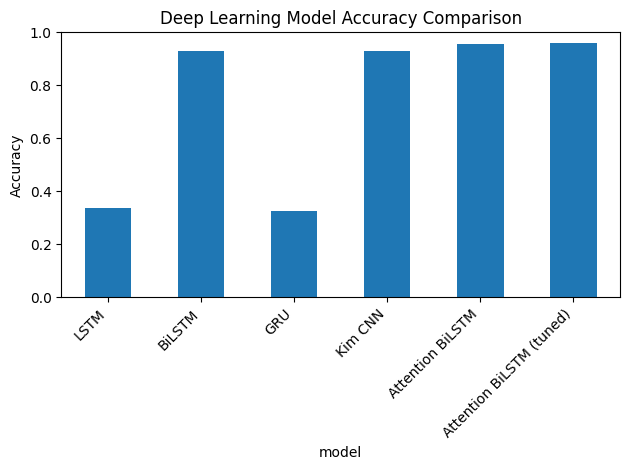

In [11]:
acc_df = (
    dl_df[['model', 'model_accuracy']]
    .drop_duplicates()
    .set_index('model')
)

acc_df.plot(kind='bar', legend=False)
plt.ylabel('Accuracy')
plt.title('Deep Learning Model Accuracy Comparison')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Macro precision, recall, F1 per model

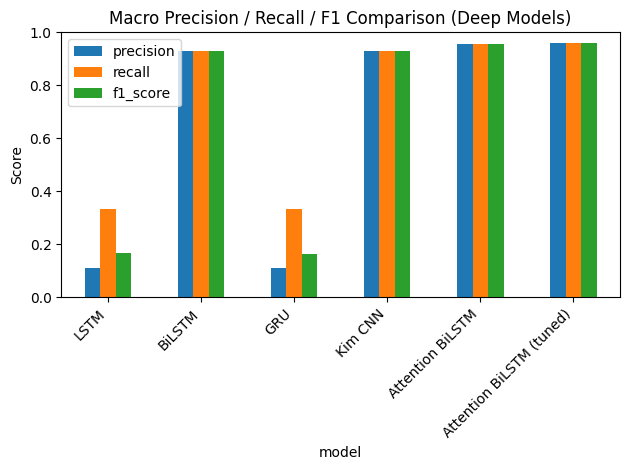

In [14]:
macro_df = (
    dl_df[dl_df['label'] == 'macro avg']
    .set_index('model')[['precision', 'recall', 'f1_score']]
)

macro_df.plot(kind='bar')
plt.ylabel('Score')
plt.title('Macro Precision / Recall / F1 Comparison (Deep Models)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Per-class F1-score comparison across models

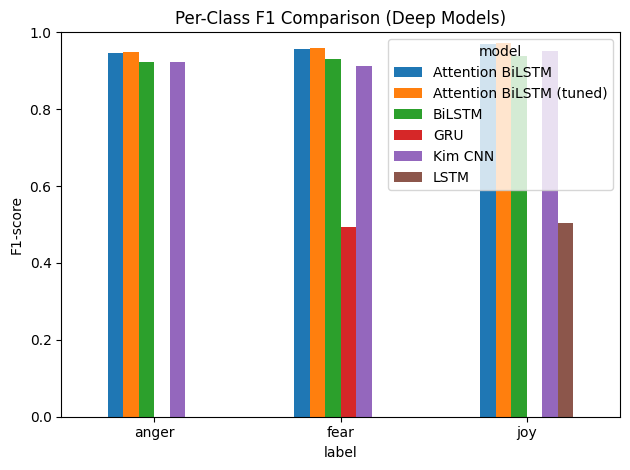

In [13]:
class_df = dl_df[~dl_df['label'].isin(['macro avg', 'weighted avg'])]

pivot_f1 = class_df.pivot(index='label', columns='model', values='f1_score')

pivot_f1.plot(kind='bar')
plt.ylabel('F1-score')
plt.title('Per-Class F1 Comparison (Deep Models)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()